# MARCH MADNESS PROJECT - JAMAL ZLITNI

In [2]:
%matplotlib inline

import string
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sbn
from altair import Chart, X, Y, Color, Scale
import altair as alt
from vega_datasets import data
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
matplotlib.style.use('ggplot')
import seaborn as sns

# large thanks to this Kaggle database that started my research and was the beginning of the data below
# https://www.kaggle.com/datasets/nishaanamin/march-madness-data

In [3]:
# read in the csv files
winners = pd.read_csv('./winners.csv')
winners = winners.dropna()
winners.head()

first_round_upsets = pd.read_csv('./first_round_upsets.csv')
first_round_upsets = first_round_upsets.dropna()
first_round_upsets.head()

upsets = pd.read_csv('./Upset Count Data.csv')
upsets = upsets.dropna()
upsets.head()

conf_data = pd.read_csv('./Tournament Conference Data.csv')
conf_data = conf_data.dropna()
conf_data.head()

trends = pd.read_csv('./Tournament Trends.csv')
trends.head()

game_data = pd.read_csv('./Tournament Game Data.csv')
game_data = game_data.dropna()
game_data.head()

team_data = pd.read_csv('./Team Stats.csv')
team_data = team_data.dropna()
team_data.head()

matchups = pd.read_csv('./Tournament Matchups.csv')
matchups = matchups.dropna()
matchups.head()

,YEAR,BY YEAR NO,BY ROUND NO,TEAM NO,TEAM,SEED,ROUND,CURRENT ROUND,SCORE
148,2023,1888,1888,1011,Alabama,1,16,64,96.0
149,2023,1887,1887,955,Texas A&M Corpus Chris,16,64,64,75.0
150,2023,1886,1886,979,Maryland,8,32,64,67.0
151,2023,1885,1885,945,West Virginia,9,64,64,65.0
152,2023,1884,1884,961,San Diego St.,5,2,64,63.0


-------------------------
# WINNERS ANALYSIS

In [3]:
print(winners.head())

   YEAR  SEED         TEAM  ROUND  KENPOM ADJUSTED EFFICIENCY  \
0  2024     1  Connecticut      1                        32.2   
1  2023     4  Connecticut      1                        25.3   
2  2022     1       Kansas      1                        25.5   
3  2021     1       Baylor      1                        29.5   
4  2019     1    Virginia       1                        35.7   

   KENPOM ADJUSTED OFFENSE  KENPOM ADJUSTED DEFENSE  KENPOM ADJUSTED TEMPO  \
0                    126.6                     94.4                   64.5   
1                    119.5                     94.2                   66.6   
2                    119.4                     93.9                   69.1   
3                    123.3                     93.8                   68.4   
4                    123.6                     87.9                   59.3   

   BARTTORVIK ADJUSTED EFFICIENCY  BARTTORVIK ADJUSTED OFFENSE  ...  \
0                            33.5                        127.1  ...  

In [4]:
print("Here are the lowest values for the following statistics that any tournament winning team has had since" + 
      " 2008, DON'T pick a team to win that has statistics lower than these: \n")
print("KENPOM ADJUSTED EFFICIENCY: ", winners['KENPOM ADJUSTED EFFICIENCY'].min())
print("KENPOM ADJUSTED OFFENSE: ", winners['KENPOM ADJUSTED OFFENSE'].min())
print("KENPOM ADJUSTED DEFENSE: ", winners['KENPOM ADJUSTED DEFENSE'].min())
print("KENPOM ADJUSTED TEMPO: ", winners['KENPOM ADJUSTED TEMPO'].min())
print("BARTTORVIK ADJUSTED EFFICIENCY: ", winners['BARTTORVIK ADJUSTED EFFICIENCY'].min())
print("BARTTORVIK ADJUSTED OFFENSE: ", winners['BARTTORVIK ADJUSTED OFFENSE'].min())
print("2PT % DEFENSE: ", winners['2PT % DEFENSE'].min())
print("3PT % DEFENSE: ", winners['3PT % DEFENSE'].min())
print("TURNOVER % DEFENSE: ", winners['TURNOVER % DEFENSE'].min())
print("WIN %: ", winners['WIN %'].min())
print("POINTS PER POSSESSION OFFENSE: ", winners['POINTS PER POSSESSION OFFENSE'].min())

Here are the lowest values for the following statistics that any tournament winning team has had since 2008, DON'T pick a team to win that has statistics lower than these: 

KENPOM ADJUSTED EFFICIENCY:  19.1
KENPOM ADJUSTED OFFENSE:  111.4
KENPOM ADJUSTED DEFENSE:  83.2
KENPOM ADJUSTED TEMPO:  59.3
BARTTORVIK ADJUSTED EFFICIENCY:  19.0
BARTTORVIK ADJUSTED OFFENSE:  111.6
2PT % DEFENSE:  38.8
3PT % DEFENSE:  27.2
TURNOVER % DEFENSE:  16.2
WIN %:  74.29
POINTS PER POSSESSION OFFENSE:  1.085


In [5]:
seed_counts = winners['SEED'].value_counts(normalize=True) * 100

# Print the results
print("When considering the odds of a specific seeding winning the tournament by going off of every prior March Madness tournament are as follows: \n")
for seed in range(1, 17):  # Assuming seeds range from 1 to 16
    if seed in seed_counts.index:
        print(f"{seed} seed: {seed_counts[seed]:.1f}%")
    else:
        print(f"{seed} seed: 0%")

When considering the odds of a specific seeding winning the tournament by going off of every prior March Madness tournament are as follows: 

1 seed: 75.0%
2 seed: 6.2%
3 seed: 6.2%
4 seed: 6.2%
5 seed: 0%
6 seed: 0%
7 seed: 6.2%
8 seed: 0%
9 seed: 0%
10 seed: 0%
11 seed: 0%
12 seed: 0%
13 seed: 0%
14 seed: 0%
15 seed: 0%
16 seed: 0%


Some notable takeaways from above are that a 1 seed has won the tournament over half the time, a 2 and 3 seed have almost the same win percentage (a 2 seed has only won one more time than a 3 seed has won), and even though a 4, 6, 7, or 8 seed have all won the tournament once, a 5 seed has actually never won!

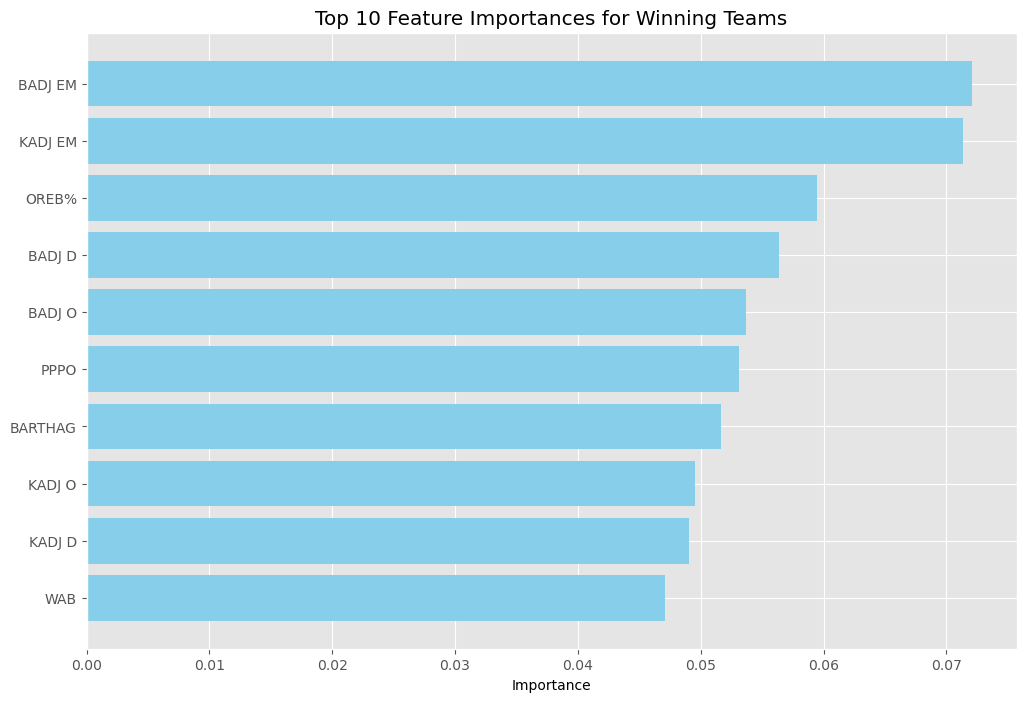

In [70]:
from sklearn.ensemble import RandomForestClassifier

selected_columns = [            # select columns for the model
    'KADJ EM', 'KADJ O', 'KADJ D', 'KADJ T', 'BADJ EM', 'BADJ O', 'BADJ D', 'BARTHAG', 
    'EFG%', 'EFG%D', 'FTR', 'FTRD', 'TOV%', 'TOV%D', 'OREB%', 'DREB%', '2PT%', '2PT%D', 
    '3PT%', '3PT%D', 'PPPO', 'PPPD', 'ELITE SOS', 'WAB'
]

X = team_data[selected_columns]
y = (team_data['ROUND'] == 1).astype(int)  # target variable is tournament winning teams

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_           # determine the feature importances
feature_names = team_data[selected_columns].columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances for Winning Teams')
plt.gca().invert_yaxis()
plt.show()

By using a random forest classifier model trained from the team stats dataset, the top 10 most influential statistics that you should pay attention to when choosing a tournament winner are shown in the bar chart above.
- BADJ EM - Bart Torvik Efficiency Margin
- KADJ EM - KenPom Efficiency Margin
- OREB% - Offensive Rebound %
- BADJ D - Bart Torvik Adjusted Defense
- BADJ O - Bart Torvik Adjusted Offence
- PPPO - Points Per Possession Offense
- BARTHAG - Bart Torvik Power Ranking
- KADJ O - KenPom Adjusted Offense
- KADJ D - KenPom Adjusted Defense
- WAB - Wins Above Bubble

----------

# TEAM STATS CORRELATION

            KADJ EM    KADJ O    KADJ D    KADJ T   BADJ EM    BADJ O  \
KADJ EM    1.000000  0.815658 -0.768610 -0.041915  0.990899  0.814159   
KADJ O     0.815658  1.000000 -0.256824  0.114639  0.823542  0.990518   
KADJ D    -0.768610 -0.256824  1.000000  0.196782 -0.744689 -0.264805   
KADJ T    -0.041915  0.114639  0.196782  1.000000 -0.035204  0.125032   
BADJ EM    0.990899  0.823542 -0.744689 -0.035204  1.000000  0.834602   
BADJ O     0.814159  0.990518 -0.264805  0.125032  0.834602  1.000000   
BADJ D    -0.760644 -0.256673  0.986859  0.211215 -0.752117 -0.264690   
BARTHAG    0.955230  0.766497 -0.748179 -0.050748  0.961653  0.773009   
EFG%       0.348381  0.614647  0.097668  0.171156  0.352134  0.599701   
EFG%D     -0.395763  0.034063  0.698801  0.273139 -0.377095  0.032565   
FTR       -0.114517 -0.127420  0.050407 -0.009172 -0.119788 -0.127107   
FTRD      -0.235250 -0.293903  0.068005  0.042303 -0.231680 -0.279176   
TOV%      -0.304719 -0.498992 -0.042722 -0.086098 -

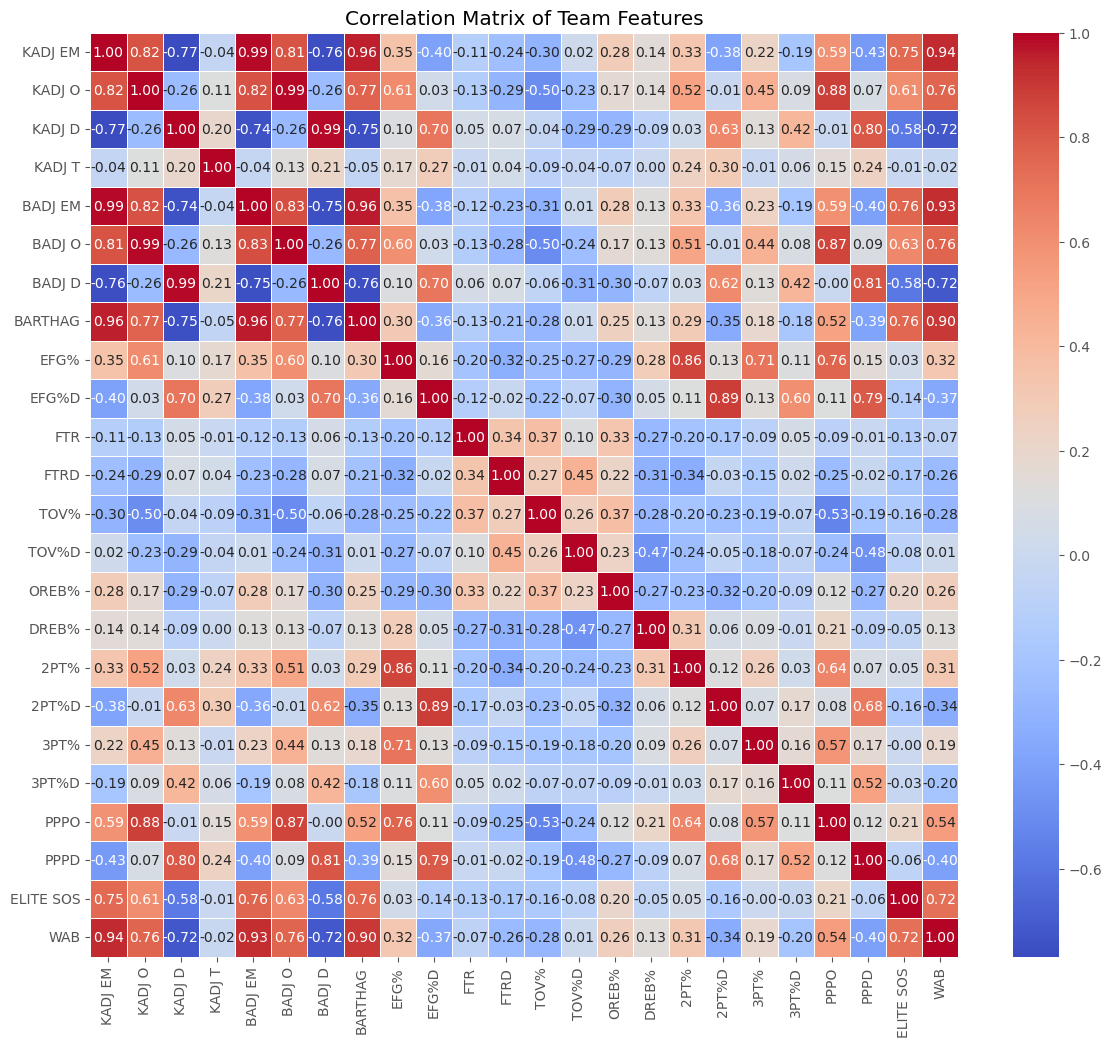

In [69]:
selected_columns = [            # select certain columns for the matrix
    'KADJ EM', 'KADJ O', 'KADJ D', 'KADJ T', 'BADJ EM', 'BADJ O', 'BADJ D', 'BARTHAG', 
    'EFG%', 'EFG%D', 'FTR', 'FTRD', 'TOV%', 'TOV%D', 'OREB%', 'DREB%', '2PT%', '2PT%D', 
    '3PT%', '3PT%D', 'PPPO', 'PPPD', 'ELITE SOS', 'WAB'
]

features = team_data[selected_columns]

features = features.fillna(features.mean())

correlation_matrix = features.corr()

print(correlation_matrix)       # print the correlation matrix

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Team Features')
plt.show()

Placeholder

-----------------

# Key Upset Factor Identification

In [13]:
# preparing data for accelerated gradient boost algorithm
team_data_selected = team_data[['TEAM NO', 'CONF'] + list(team_data.columns[10:])]
matchups_selected = matchups[['YEAR', 'TEAM NO', 'SEED', 'ROUND', 'SCORE']]

combined_df = pd.merge(matchups_selected, team_data_selected, on=['TEAM NO'], how='left')

print(combined_df.head())

   YEAR  TEAM NO  SEED  ROUND  SCORE  CONF  K TEMPO  K TEMPO RANK   KADJ T  \
0  2023     1011     1     16   96.0   SEC  72.8260            12  72.7469   
1  2023      955    16     64   75.0  Slnd  70.6680            53  69.2572   
2  2023      979     8     32   67.0   B10  64.5455           335  64.6104   
3  2023      945     9     64   65.0   B12  69.8826            84  68.8537   
4  2023      961     5      2   63.0   MWC  66.5126           254  66.0090   

   KADJ T RANK  ...  BADJT RANK  AVG HGT RANK  EFF HGT RANK  EXP RANK  \
0            4  ...           4            44            10       353   
1           80  ...          86           359           351         9   
2          312  ...         311            60           136        47   
3          104  ...         114           119            76        35   
4          252  ...         246           240           152        10   

   TALENT RANK  FT% RANK  OP FT% RANK  PPPO RANK  PPPD RANK  ELITE SOS RANK  
0           19

----------------------------------------------------------
# FIRST ROUND UPSET ANALYSIS

In [6]:
print(first_round_upsets)

    YEAR  one v sixteen  two v fifteen  three v fourteen  four v thirteen  \
0   2024          0.000         0.0000               1.0           1.0000   
1   2023          1.000         1.0000               0.0           1.0000   
2   2022          0.000         1.0000               0.0           0.0000   
3   2021          0.000         1.0000               1.0           2.0000   
4   2019          0.000         0.0000               0.0           1.0000   
5   2018          1.000         0.0000               0.0           2.0000   
6   2017          0.000         0.0000               0.0           0.0000   
7   2016          0.000         1.0000               1.0           1.0000   
8   2015          0.000         0.0000               2.0           0.0000   
9   2014          0.000         0.0000               1.0           0.0000   
10  2013          0.000         1.0000               1.0           1.0000   
11  2012          0.000         2.0000               0.0           1.0000   

In [7]:
first_round_upsets['one v sixteen'] = first_round_upsets['one v sixteen'].astype(int)
first_round_upsets['two v fifteen'] = first_round_upsets['two v fifteen'].astype(int)
first_round_upsets['three v fourteen'] = first_round_upsets['three v fourteen'].astype(int)
first_round_upsets['four v thirteen'] = first_round_upsets['four v thirteen'].astype(int)
first_round_upsets['five v twelve'] = first_round_upsets['five v twelve'].astype(int)
first_round_upsets['six v eleven'] = first_round_upsets['six v eleven'].astype(int)
first_round_upsets['seven v ten'] = first_round_upsets['seven v ten'].astype(int)

print("Using data from 2008 onwards: \n")
print("Here are the average number of first round upsets: ", first_round_upsets['TOTAL'].mean().round(2))
print("\nAverage number of first round upsets per year broken down by seeding matchup:")

print("1 vs 16: ", first_round_upsets['one v sixteen'].mean().round(2))
print("2 vs 15: ", first_round_upsets['two v fifteen'].mean().round(2))
print("3 vs 14: ", first_round_upsets['three v fourteen'].mean().round(2))
print("4 vs 13: ", first_round_upsets['four v thirteen'].mean().round(2))
print("5 vs 12: ", first_round_upsets['five v twelve'].mean().round(2))
print("6 vs 11: ", first_round_upsets['six v eleven'].mean().round(2))
print("7 vs 10: ", first_round_upsets['seven v ten'].mean().round(2))

print("\nHere are the percentage of years that have had at least one upset by seed matchup: ")
print("1 vs 16: ", (((first_round_upsets['one v sixteen'] > 0).sum() / len(first_round_upsets['one v sixteen'])) * 100).round(2))
print("2 vs 15: ", (((first_round_upsets['two v fifteen'] > 0).sum() / len(first_round_upsets['two v fifteen'])) * 100).round(2))
print("3 vs 14: ", (((first_round_upsets['three v fourteen'] > 0).sum() / len(first_round_upsets['three v fourteen'])) * 100).round(2))
print("4 vs 13: ", (((first_round_upsets['four v thirteen'] > 0).sum() / len(first_round_upsets['four v thirteen'])) * 100).round(2))
print("6 vs 11: ", (((first_round_upsets['six v eleven'] > 0).sum() / len(first_round_upsets['six v eleven'])) * 100).round(2))
print("7 vs 10: ", (((first_round_upsets['seven v ten'] > 0).sum() / len(first_round_upsets['seven v ten'])) * 100).round(2))

print("\nHere are the percentage of years that have had at least two upsets by seed matchup: ")
print("1 vs 16: ", (((first_round_upsets['one v sixteen'] > 1).sum() / len(first_round_upsets['one v sixteen'])) * 100).round(2))
print("2 vs 15: ", (((first_round_upsets['two v fifteen'] > 1).sum() / len(first_round_upsets['two v fifteen'])) * 100).round(2))
print("3 vs 14: ", (((first_round_upsets['three v fourteen'] > 1).sum() / len(first_round_upsets['three v fourteen'])) * 100).round(2))
print("4 vs 13: ", (((first_round_upsets['four v thirteen'] > 1).sum() / len(first_round_upsets['four v thirteen'])) * 100).round(2))
print("6 vs 11: ", (((first_round_upsets['six v eleven'] > 1).sum() / len(first_round_upsets['six v eleven'])) * 100).round(2))
print("7 vs 10: ", (((first_round_upsets['seven v ten'] > 1).sum() / len(first_round_upsets['seven v ten'])) * 100).round(2))

Using data from 2008 onwards: 

Here are the average number of first round upsets:  7.19

Average number of first round upsets per year broken down by seeding matchup:
1 vs 16:  0.12
2 vs 15:  0.41
3 vs 14:  0.47
4 vs 13:  0.88
5 vs 12:  1.59
6 vs 11:  2.0
7 vs 10:  1.53

Here are the percentage of years that have had at least one upset by seed matchup: 
1 vs 16:  11.76
2 vs 15:  35.29
3 vs 14:  41.18
4 vs 13:  70.59
6 vs 11:  100.0
7 vs 10:  100.0

Here are the percentage of years that have had at least two upsets by seed matchup: 
1 vs 16:  0.0
2 vs 15:  5.88
3 vs 14:  5.88
4 vs 13:  17.65
6 vs 11:  70.59
7 vs 10:  35.29


Takeaways
- This shows that 40% of the time there will be a 5/12 upset, and the same for 3/14. 
- In about 3 out of 4 years there will be a 4/13 upset
- There is an EXTREMELY LIKELY chance that a 6/11 and 7/10 upset will happen, there has been at least one of each in every tournament for the last 15 years.
- In fact, more often than not there are 2 or more 6/11 upsets in the same year than

-------------------------------------

# TOTAL UPSET ANALYSIS (seed differential of 3 or more)

In [8]:
upsets

,YEAR,FIRST ROUND,SECOND ROUND,SWEET 16,ELITE 8,FINAL 4,TOTAL
0,2024.0,8.0,1.0,4.0,1.0,0.0,14.0
1,2023.0,5.0,4.0,4.0,2.0,0.0,15.0
2,2022.0,7.0,5.0,4.0,0.0,1.0,17.0
3,2021.0,9.0,6.0,2.0,1.0,0.0,18.0
4,2019.0,8.0,0.0,1.0,2.0,0.0,11.0
5,2018.0,6.0,5.0,3.0,1.0,0.0,15.0
6,2017.0,5.0,4.0,2.0,2.0,0.0,13.0
7,2016.0,10.0,2.0,0.0,1.0,0.0,13.0
8,2015.0,5.0,3.0,1.0,1.0,0.0,10.0
9,2014.0,7.0,5.0,3.0,2.0,2.0,19.0


FROM 2008 ONWARDS:

In [9]:
print('The average first round upsets: ', upsets["FIRST ROUND"].mean().round(2))
print('The average second round upsets: ', upsets["SECOND ROUND"].mean().round(2))
print('The average sweet 16 upsets: ', upsets["SWEET 16"].mean())
print('The average elite 8 upsets: ', upsets["ELITE 8"].mean())
print('The average final 4 upsets: ', upsets["FINAL 4"].mean())
print('The average total tournament upsets: ', upsets["TOTAL"].mean().round(2))

The average first round upsets:  7.19
The average second round upsets:  3.19
The average sweet 16 upsets:  2.125
The average elite 8 upsets:  1.1875
The average final 4 upsets:  0.1875
The average total tournament upsets:  13.88


In [10]:
print('Misc stats')
print('There have always been at least ', upsets["FIRST ROUND"].min(), ' upsets in the first round, but there has not been more than ', upsets["FIRST ROUND"].max())
print('There are 2 or more upsets in the second round ', (round(len(upsets[upsets["SECOND ROUND"] >= 2]) / len(upsets["SECOND ROUND"]) * 100, 2)), '% of the time')
print('There are 2-4 upsets in the sweet 16 ', (round(len(upsets[upsets["SWEET 16"] >= 2]) / len(upsets["SWEET 16"]) * 100, 2)), '% of the time')

Misc stats
There have always been at least  5.0  upsets in the first round, but there has not been more than  10.0
There are 2 or more upsets in the second round  81.25 % of the time
There are 2-4 upsets in the sweet 16  68.75 % of the time


In [11]:
print('There is not a distinguishably noticable trend for the total upsets in the tournament as shown in this chart:')
Chart(upsets).mark_bar().encode(x='YEAR', y='TOTAL')

There is not a distinguishably noticable trend for the total upsets in the tournament as shown in this chart:


alt.Chart(...)

In [12]:
alt.Chart(upsets).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='YEAR:N'      # sort the colors of the circles by year
).properties(
    width=150,
    height=150
).repeat(     # make scatter plots for each comparing each data column to every other column
    row=['FIRST ROUND', 'SECOND ROUND', 'SWEET 16', 'ELITE 8', 'FINAL 4', 'TOTAL'],
    column=['FIRST ROUND', 'SECOND ROUND', 'SWEET 16', 'ELITE 8', 'FINAL 4', 'TOTAL']
).interactive()

alt.RepeatChart(...)

Using the correlation charts above, I can conclude that the columns with the largest correlation are the second round with the total upsets, and the sweet 16 with the total upsets. Both of these chars have a clear trend line that the chart follows, it is clear in these that the more upsets in these two rounds equates to the higher total upset years. The first round upsets with the total upsets had way too many outliers and plot points that didn't follow a trend.

-------------------------------

# CONFERENCE DATA

In [15]:
# group the conference data sheet by conference and only keep the columns we want to sum (amount of times conferences have made it to certain stages of the tourney)
group_by_conf = conf_data.groupby('CONFERENCE')[['CHAMP COUNT', 'FINALS COUNT', 'FINAL 4 COUNT', 'ELITE 8 COUNT', 'SWEET 16 COUNT']].sum().reset_index()
print('From 2008-2022, here are the number of teams that have made it to each stage of the tournament grouped by conference:')
group_by_conf

From 2008-2022, here are the number of teams that have made it to each stage of the tournament grouped by conference:


,CONFERENCE,CHAMP COUNT,FINALS COUNT,FINAL 4 COUNT,ELITE 8 COUNT,SWEET 16 COUNT
0,A10,0,0,0,2,7
1,ACC,5,7,12,24,42
2,AMER,1,1,2,2,4
3,Amer,0,0,1,1,1
4,B10,0,5,10,16,39
5,B12,3,5,7,19,35
6,BE,6,6,12,19,33
7,CUSA,0,1,1,1,2
8,HORZ,0,2,2,2,2
9,MVC,0,0,2,2,4


Key Takeaways:

- The winning team has always been in one of these five conferences: ACC (Atlantic Coast Conference), AMER (American Athletic Conference), B12 (Big 12), BE (Big East), and SEC (Southeastern Conference)
- The conference with the most winning ratio in the finals is the Big East, a team from the BE has made it to the finals 4 times and they have won the title all four times.
- The coference with the most losing ratio in the finals is the Big 10, the B10 has made it to the title game 4 times and has lost every single time.
- The Mountain West Conference (MWC) has not made it past the sweet 16.
- Despite having 19 appearances in the sweet 16, the PAC-12 (P12) have not made it to a finals game before.
- Among the conferences with a high number of sweet 16 appearances (15+), the ACC, BE, and SEC have the best conversion rates going into the elite 8, with the ACC moving on to the elite 8 54% of the time, the SEC moving on 68% of the time, and the BE moving on 59% of the time. The conferences with the worst conversion rate are the B10 and P12. The Big 10 has only moved on to the elite 8 39% of the time and the P12 has moved on only 37% of the time.

--------------------------------------

# COMPARING TO THE MOST RECENT TOURNAMENT (2023)

- The winner of this year's tournament (UConn) was a four seed heading into the tournament. In the tournaments history, UConn is the second ever four seed to win the championship.
- Despite having some of the most insane upset runs and one of the lowest average final four seed totals ever, this year's tournament rounds out the bottom edge of total first round upsets (since 2008) with only 5. 
- I found the stats following the upsets by round of the tournament in comparison with this year to be the most interesting. With five first round upsets, 2023 is below the average of 7.13 first round upsets. In contrast, 2023 is larger than the average by a considerable amount in terms of upsets for the rounds of the second round, sweet 16, and elite 8.
     - Average for second round: 3.33   || 2023 second round upsets: 4
     - Average for sweet 16: 2          || 2023 sweet 16 upsets: 4
     - Average for elite 8: 1.2         || 2023 elite 8 upsets: 2
- With all of that in consideration, 2023 ended up higher than average in terms of total upsets at 15 compared to the average of 13.87.
- (since 2008) Continuing the memorable considerations of 2023, this year's tournament shook up the conference data as well. With UConn coming out on top, nothing notable changes, the highly successfule Big East (BE) gain another champion and now tie the ACC for most wins. Moving past UConn, the championship losing team was 5 seed San Diego State and the rest of the final four consisted of 9 seed FAU and 5 seed Miami.
     - San Diego State made history becoming the first Mountain West Conference (MWC) team to make it to the championship game. In fact, a MWC team has never made it past the sweet 16 before San Diego State's run this year!
     - 9 seed Florida Atlantic University (FAU) became the second ever Conference USA (CUSA) team to make it past the sweet 16.
     - Miami did not make notable differences in the conference data as they are an ACC team.
     
     
The unpredictable but exciting behavior of this tournament is what I love about it. Having unknown teams/schools show up and make deep runs or even just one big upset allows under the radar teams to shine on the biggest stage!

--------------------------------------

# TLDR Takeaways

When picking a winner, try to stay away from teams with stats lower than these:

- KENPOM ADJUSTED EFFICIENCY:  19.1
- KENPOM ADJUSTED OFFENSE:  111.4
- KENPOM ADJUSTED DEFENSE:  83.2
- KENPOM ADJUSTED TEMPO:  59.3
- BARTTORVIK ADJUSTED EFFICIENCY:  19.0
- BARTTORVIK ADJUSTED OFFENSE:  111.6
- 2PT % DEFENSE:  38.8
- 3PT % DEFENSE:  27.2
- TURNOVER % DEFENSE:  17.8
- WIN %:  74.29
- POINTS PER POSSESSION OFFENSE:  1.085ENSE:  1.085

# Winner Seedings

- 1 seeds have the highest chance of winning (64.9%), followed by 2 and 3 seeds with similar win percentages.
- 5 seeds have never won the tournament, and 4, 6, 7, and 8 seeds have won once each.

# Upset Trends

- In about 3 out of 4 years there will be a 4/13 upset
- There is an EXTREMELY LIKELY chance that a 6/11 and 7/10 upset will happen, there has been at least one of each in every tournament for the last 15 years
- More often than not, there are 2 or more 6/11 upsets in the same year Elite 8.

# Conference Trends

- Since 2008, winning teams have only come from the ACC, AMER, B12, BE, and SEC conferences.
- The Big East has the best finals winning ratio (4/4), while the Big 10 has the worst (0/4).
- The PAC-12 has 19 sweet 16 appearances but has never reached the finals.

--------------------------------------

# Conclusion

Unlocking the secrets to March Madness success involves delving into the intricacies of team statistics, season to season variability, seeding odds, upset trends, conference performances, and luck. Teams boasting robust overall efficiency, favorable seeding, and a knack for upsetting specific matchups take center stage in the prediction game. Keeping a keen eye on how conferences perform and convert in later rounds adds an extra layer of precision to your predictive playbook. So, gear up, analyze wisely, and let the madness unfold!

--------------------------------------

# Updates

I started this project in the middle of March Madness 2023. I plan to update thi project each year with new findings/trend changes, plus the outcomes of my brackets and what worked/didn't work from following the guidelines found by using this analysis!

-------------------------------------------

# 2024

I did win both of my bracket challenges this year by using this project as an aide! Most notably, I chose the correct tournament winner pick of UConn using this analysis. I am planning to make quite a few changes/additions here this year! I will list some down below:
- Update all data with 2024 info
- Modify some of the hard-coded/printed analysis in this notebook so that it will auto update with the new CSV cells
- Implement a sci-kit learn pipeline
- Add an acc gradient boosting algorithm (XGBoost)
- Learn to use docker with this
- Add relevant spreadsheets to GitHub
- Add a requirements.txt file